# LDA module
In this otebook, we performed our unsupervised learning task - LDA Topic modelling.  

The analysis follows a systematic approach of :
1. Exploration / Hyperparameter tuning
2. Sensitivity analysis - Coherence score / perplexity score
3. Topic exploration using pyLDAvis


In [ ]:
import pandas as pd
import folium
import math
import numpy as np
import re
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from gensim.models import CoherenceModel
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim import corpora
import string

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # comment out if already downloaded
stop_words = set(stopwords.words('english'))
nltk.download('punkt')     # comment out if already downloaded
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim import corpora, models


In [3]:
# drop column
from google.colab import drive
drive.mount("/content/drive")

## for jupyter lab
#path="Reviews_w_sentiment_score_data.csv"


## for Colab
path="/content/drive/MyDrive/M2/Reviews_w_sentiment_score_data.csv"


reviews_df = pd.read_csv(path, lineterminator = '\n')
LDA_df = reviews_df.copy()

# LDA_df = LDA_df.drop('cleaned_comments_nltk', axis=1)

Mounted at /content/drive


In [4]:
LDA_df.head()

,Unnamed: 0,listing_id,reviewer_name,comments2,id,final_review_score,score_label,Sentiment_Score,Sentiment,normalized_Sentiment_score,normalize_rating_score
0,0,109,Edwin,The host canceled my reservation the day befor...,109,4.285714,high,0.0000,Neutral,2.50,4.25
1,1,109,Jenn,Me and two friends stayed for four and a half ...,109,4.285714,high,0.9316,Positive,4.75,4.25
2,2,2708,Kuberan,i had a wonderful stay. Everything from start ...,2708,4.912857,high,0.8126,Positive,4.50,5.00
3,3,2708,Camilla,Charles is just amazing and he made my stay sp...,2708,4.912857,high,0.9909,Positive,5.00,5.00
4,4,2708,Fallon,Staying with Chas was an absolute pleasure. He...,2708,4.912857,high,0.9672,Positive,5.00,5.00


## 1. Exploration / Hyperparameter tuning

The goal of the data_cleaning function is to preprocess and clean the input text data to make it suitable for further analysis or modeling. The cleaning process involves multiple steps:

1. Converting text to lowercase and removing newline characters.
2. Removing symbols and punctuation.
3. Removing common and specific stopwords to reduce noise.
4. Removing numbers.
5. Optionally lemmatizing words to reduce them to their base or root form.
6. Finally, the function tokenizes the cleaned text and returns a list of words (tokens).

This preprocessing stage is vital for our Air Bnb Natural Language Processing (NLP) task as it helps in reducing the dimensionality of the data, removing unnecessary noise and making the data more suitable for extracting meaningful insights or for use in the LDA model.

It is an iterative process. We generate a couple of times the LDA chart to see what other words which came out in the topic modelling which doesn't make sense at all and added them to the existing stopwords we have.


In [5]:
def data_cleaning(text, stem = "None"):

    final_string = ""

    # cleaning
    text = text.lower()
    text = re.sub(r'\n', '', text)

    # removing symbols and punctuation
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    text = text.split()

    # Add stopwords
    extra_words = nltk.corpus.stopwords.words("english")
    extend_stopwords = ['hi', 'im','i','los', 'angeles','stay','flat','room','place','apartment','u','would','really',
                        'airbnb','good','nice','great','didnt','lovely','amazing', 'bnb', 'santa', 'monica', 'well',
                        'not', 'highly', 'thank', 'perfect', 'everything', 'not', 'house', 'home', 'can', 'everything', 'ive', 'ever', 'one', 'like', 'felt', 'loved', 'super', 'definitely', 'recommend'
                       'back', 'come', 'venice', 'la', 'night', 'get', 'even', 'day']
    extra_words.extend(extend_stopwords)

    cleaned_text = [word for word in text if not word in extra_words]

    # getting rid of numbers
    cleaned_text = [re.sub(r'\w*\d\w*', '', w) for w in cleaned_text]

    # Stem or Lemmatize
    if stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in cleaned_text]
    else:
        text_stemmed = cleaned_text

    stem_clean = [word for word in text_stemmed if not word in extra_words]
    final_string = ' '.join(stem_clean)

    result = nltk.word_tokenize(final_string)

    return result

In [6]:
# Create new column
# functions take a long time to run because of the data size, so we saved it out in a separate csv file.
LDA_df['cleaned_comments_nltk'] = LDA_df['comments2'].apply(data_cleaning, stem='Lem')

In [23]:
LDA_df.to_csv('/content/drive/MyDrive/M2/LDA_df.csv')

In [24]:
path="/content/drive/MyDrive/M2/LDA_df.csv"

LDA_df = pd.read_csv(path)

In [25]:
LDA_df.head()

,Unnamed: 0.1,Unnamed: 0,listing_id,reviewer_name,comments2,id,final_review_score,score_label,Sentiment_Score,Sentiment,normalized_Sentiment_score,normalize_rating_score,cleaned_comments_nltk,cleaned_comments_joined
0,0,0,109,Edwin,The host canceled my reservation the day befor...,109,4.285714,high,0.0000,Neutral,2.50,4.25,"['host', 'canceled', 'reservation', 'arrival']",host canceled reservation arrival
1,1,1,109,Jenn,Me and two friends stayed for four and a half ...,109,4.285714,high,0.9316,Positive,4.75,4.25,"['two', 'friend', 'stayed', 'four', 'half', 'm...",two friend stayed four half month comfortable ...
2,2,2,2708,Kuberan,i had a wonderful stay. Everything from start ...,2708,4.912857,high,0.8126,Positive,4.50,5.00,"['wonderful', 'start', 'end', 'back']",wonderful start end back
3,3,3,2708,Camilla,Charles is just amazing and he made my stay sp...,2708,4.912857,high,0.9909,Positive,5.00,5.00,"['charles', 'made', 'special', 'helpful', 'abs...",charles made special helpful absolutely polite...
4,4,4,2708,Fallon,Staying with Chas was an absolute pleasure. He...,2708,4.912857,high,0.9672,Positive,5.00,5.00,"['staying', 'chas', 'absolute', 'pleasure', 'a...",staying chas absolute pleasure accommodating r...


In [8]:
# drop line items with nan
LDA_df = LDA_df.dropna(subset=['cleaned_comments_nltk'])
LDA_df.shape

(1311152, 12)

In [9]:
# # replace
# LDA_df['cleaned_comments_nltk'] = LDA_df['cleaned_comments_nltk'].astype(str)
# LDA_df['cleaned_comments_nltk'] = LDA_df['cleaned_comments_nltk'].str.replace('[', '').str.replace(']', '').str.replace(',', '').str.replace("'", "")

In [10]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
#LDA_df.head()

In [12]:
### testing to make sure .get_feature_names_out() works

from sklearn.feature_extraction.text import TfidfVectorizer

corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

# Now you should be able to call get_feature_names without any issue
print(vectorizer.get_feature_names_out() )

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']


The goal of the next function count_vectorizer is to transform the text data into numerical vectors which can be used in machine learning models. The transformation is done using the TF-IDF (Term Frequency-Inverse Document Frequency) method, which is a popular technique in Natural Language Processing (NLP).



In [13]:
count_vectorizer = TfidfVectorizer(
                        strip_accents='unicode', #strip_accents='unicode': This removes accents and performs other character normalization during the preprocessing step.





                        preprocessor=None, #This means that no preprocessor is applied to the data before tokenizing it.
                        analyzer='word', #This means that features should be made of word n-grams; i.e., the function will analyze the data at the word level.
                        ngram_range=(1, 2),
                        min_df=10, #min_df=10: This ignores terms that appear in fewer than 10 documents of the corpus.
                        use_idf=True, smooth_idf=True, #These parameters enable the inverse document frequency reweighting, which helps in reducing the weight of words that occur very frequently in the corpus.
                        max_features = 5000) #This limits the number of features (vocabulary size) to the top 5000, ranked by term frequency across the corpus.

In [14]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}:")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

After the TfidfVectorizer is defined, we used .fit() method on it with our corpus as the argument, to transform the air bnb text data into a matrix of TF-IDF features.

In [15]:
# Joining the words into a single string for each comment
LDA_df['cleaned_comments_joined'] = LDA_df['cleaned_comments_nltk'].apply(' '.join)

# Now fit the count vectorizer on the joined comments
count_vectorizer.fit(LDA_df['cleaned_comments_joined'])

TfidfVectorizer(max_features=5000, min_df=10, ngram_range=(1, 2),
                strip_accents='unicode')

In [16]:
### Corpora and Dictionary are from the Gennism module

dictionary = corpora.Dictionary(LDA_df['cleaned_comments_nltk'])
models
doc_term_matrix = [dictionary.doc2bow(text) for text in LDA_df['cleaned_comments_nltk']]

## 2. Sensitivity analysis - Coherence score / perplexity score

The following function was used to calculate the coherence score.

In [17]:
from tqdm import tqdm

# Range to find the best number of topics
start = 2
stop = 12
step = 2

def calculate_coherence(lda_model, texts, dictionary):

    coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['Num_Topics', 'Coherence_Score'])

# Apply to LDA model
for num_topics in tqdm(range(start, stop, step), desc="Calculating Coherence"):


    lda_model = models.LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=42)
    coherence = calculate_coherence(lda_model, LDA_df['cleaned_comments_nltk'], dictionary)
    # Append results to the DataFrame
    results_df = results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)


Calculating Coherence:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-17-b657c5d932c6>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)
Calculating Coherence:  20%|██        | 1/5 [07:08<28:32, 428.14s/it]<ipython-input-17-b657c5d932c6>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Num_Topics': num_topics, 'Coherence_Score': coherence}, ignore_index=True)
Calculating Coherence:  40%|████      | 2/5 [16:29<25:19, 506.57s/it]<ipython-input-17-b657c5d932c6>:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({'Num_Topics': num_topics, 'Coherence_Scor

In [20]:
results_df.to_csv('/content/drive/MyDrive/M2/Coherence_Score_by_Topic.csv')

In [25]:
results_df

,Num_Topics,Coherence_Score
0,2.0,0.541738
1,4.0,0.596889
2,6.0,0.638560
3,8.0,0.611229
4,10.0,0.597881


In [27]:
path="/content/drive/MyDrive/M2/Coherence_Score_by_Topic.csv"


LDA_coherence_score_df = pd.read_csv(path, lineterminator = '\n')

In [28]:
LDA_coherence_score_df

,Unnamed: 0,Num_Topics,Coherence_Score
0,0,2.0,0.541738
1,1,4.0,0.596889
2,2,6.0,0.638560
3,3,8.0,0.611229
4,4,10.0,0.597881


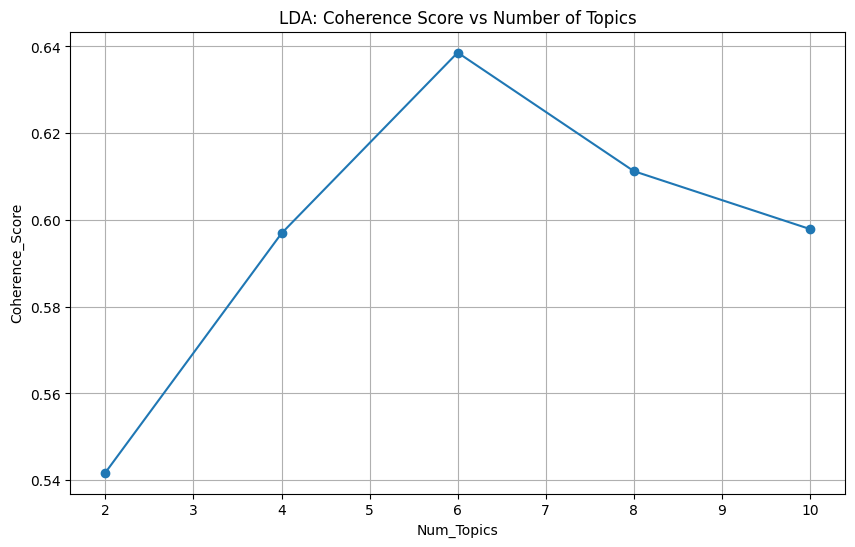

In [40]:
plt.figure(figsize=(10, 6))

plt.plot(LDA_coherence_score_df['Num_Topics'], LDA_coherence_score_df['Coherence_Score'], marker='o')

plt.xlabel('Num_Topics')
plt.ylabel('Coherence_Score')
plt.title('LDA: Coherence Score vs Number of Topics')

plt.grid(True)
plt.show()

In [18]:
from tqdm import tqdm

# Range to find the best number of topics
start = 2
stop = 12
step = 2

# Calculations to find best number of topics
def calculate_perplexity(lda_model, doc_term_matrix):
     return lda_model.log_perplexity(doc_term_matrix)

perplexity_results_df = pd.DataFrame(columns=['Num_Topics', 'Perplexity_Score'])

# Apply to LDA model
for num_topics in tqdm(range(start, stop, step), desc="Calculating Perplexity_Score"):
     lda_model = models.LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=num_topics, random_state=42)
     perplexity = calculate_perplexity(lda_model, doc_term_matrix)
     perplexity_results_df = perplexity_results_df.append({'Num_Topics': num_topics, 'Perplexity_Score': perplexity}, ignore_index=True)

Calculating Perplexity_Score:   0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-18-7cddf270ee62>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perplexity_results_df = perplexity_results_df.append({'Num_Topics': num_topics, 'Perplexity_Score': perplexity}, ignore_index=True)
Calculating Perplexity_Score:  20%|██        | 1/5 [12:07<48:29, 727.32s/it]<ipython-input-18-7cddf270ee62>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perplexity_results_df = perplexity_results_df.append({'Num_Topics': num_topics, 'Perplexity_Score': perplexity}, ignore_index=True)
Calculating Perplexity_Score:  40%|████      | 2/5 [27:14<41:38, 832.85s/it]<ipython-input-18-7cddf270ee62>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  perp

In [19]:
perplexity_results_df.to_csv('/content/drive/MyDrive/M2/Perplexity_Score_by_Topic.csv')

In [20]:
perplexity_results_df

,Num_Topics,Perplexity_Score
0,2.0,-7.398622
1,4.0,-7.409868
2,6.0,-7.513597
3,8.0,-7.636319
4,10.0,-7.881360


In [21]:
path="/content/drive/MyDrive/M2/Perplexity_Score_by_Topic.csv"


LDA_perplexity_score_df = pd.read_csv(path, lineterminator = '\n')

In [22]:
LDA_perplexity_score_df

,Unnamed: 0,Num_Topics,Perplexity_Score
0,0,2.0,-7.398622
1,1,4.0,-7.409868
2,2,6.0,-7.513597
3,3,8.0,-7.636319
4,4,10.0,-7.881360


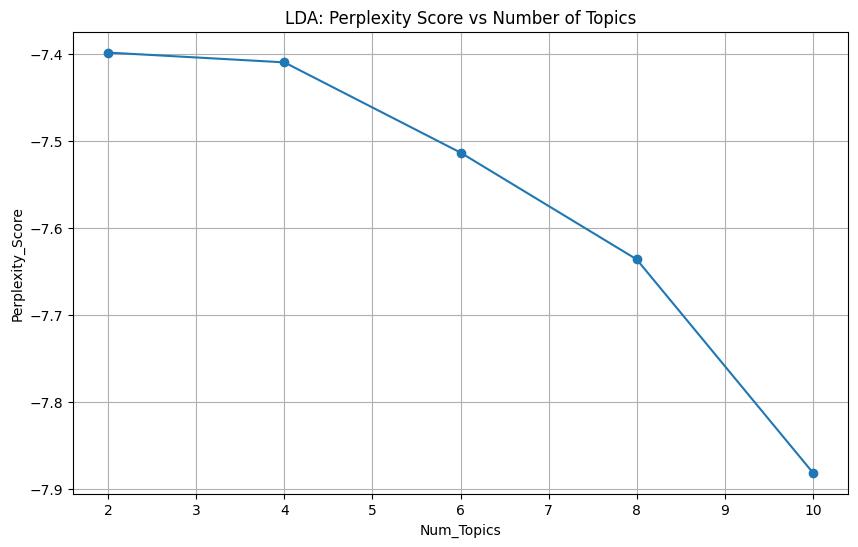

In [41]:
plt.figure(figsize=(10, 6))

plt.plot(LDA_perplexity_score_df['Num_Topics'], LDA_perplexity_score_df['Perplexity_Score'], marker='o')

plt.xlabel('Num_Topics')
plt.ylabel('Perplexity_Score')
plt.title('LDA: Perplexity Score vs Number of Topics')

plt.grid(True)
plt.show()

In [ ]:
### 20 to 21 min
#%%time

RANDOM_SEED = 42
number_topics = 6 ### based on coherence score
number_words = 10

bag_of_words = count_vectorizer.transform(LDA_df['cleaned_comments_joined'])

# Create and fit the LDA model
lda = LDA(n_components=number_topics, random_state=RANDOM_SEED, n_jobs=-1, learning_method='online')
lda.fit(bag_of_words)



LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=42)

In [ ]:
print_topics(lda, count_vectorizer, number_words)


Topic #1:
easy parking location clean close check comfortable area host safe

Topic #2:
host best experience location back always feel made clean recommend

Topic #3:
host location clean responsive wonderful comfortable location clean accommodating clean comfortable host responsive

Topic #4:
neighborhood awesome quiet convenient helpful clean back spacious time quiet neighborhood

Topic #5:
host exactly recommend clean time needed beautiful comfortable staying picture

Topic #6:
beautiful view space location host getaway little comfy outdoor peaceful forward

Topic #7:
bed value bathroom overall parking issue kitchen little thing clean

Topic #8:
recommend anyone staying recommend anyone thanks looking hospitality location people host

Topic #9:
clean quick communication excellent easy price enjoyed location recommended cute

Topic #10:
beach restaurant distance walking walking distance close walk shop location short


## 3. Topic exploration using pyLDAvis
Leveraging the instruction provided in the SIADS 543 Unsupervised Learning course, we employed pyLDAvis for our topic modelling exploration. The coursework material and the resource at https://github.com/bmabey/pyLDAvis served as guides for our implementation process.

In [ ]:
def lda_gen(clean_data):

  # Making dictionary
    dictionary = corpora.Dictionary(clean_data)
  # Remove extremes
    dictionary.filter_extremes(no_below=2, no_above=0.5)
  # Making corpus
    corpus = [dictionary.doc2bow(text) for text in clean_data]
  # Making model
    num_topics = 6 #### since coherene score shows best number of topics is 6
    chunksize = 2000
    passes = 20
    iterations = 400
    eval_every = None

    temp = dictionary[0]
    id2word = dictionary.id2token

    model = LdaModel(
      corpus=corpus,
      id2word=id2word,
      chunksize=chunksize,
      alpha='auto',
      eta='auto',
      iterations=iterations,
      num_topics=num_topics,
      passes=passes,
      eval_every=eval_every
  )
    return model

In [ ]:
def print_topics(sentiment):

    if sentiment == 'pos':

        dictionary = corpora.Dictionary(positive_df['cleaned_comments_nltk'])
        corpus = [dictionary.doc2bow(text) for text in positive_df['cleaned_comments_nltk']]
        top_topics = lda_gen(positive_df['cleaned_comments_nltk']).top_topics(corpus)
    elif sentiment == 'neg':
        dictionary = corpora.Dictionary(negative_df['cleaned_comments_nltk'])
        corpus = [dictionary.doc2bow(text) for text in negative_df['cleaned_comments_nltk']]
        top_topics = lda_gen(negative_df['cleaned_comments_nltk']).top_topics(corpus)
    elif sentiment == 'neu':
        dictionary = corpora.Dictionary(neutral_df['cleaned_comments_nltk'])
        corpus = [dictionary.doc2bow(text) for text in neutral_df['cleaned_comments_nltk']]
        top_topics = lda_gen(neutral_df['cleaned_comments_nltk']).top_topics(corpus)

    print(top_topics)

In [ ]:
#Positive sentiment dataframe
positive_df = LDA_df[LDA_df['Sentiment']=='Positive']
#Negative sentiment dataframe
negative_df = LDA_df[LDA_df['Sentiment']=='Negative']
#Neutral sentiment dataframe
neutral_df = LDA_df[LDA_df['Sentiment']=='Neutral']

In [ ]:
neutral_df.head()

,Unnamed: 0,listing_id,reviewer_name,comments2,id,final_review_score,score_label,Sentiment_Score,Sentiment,normalized_Sentiment_score,normalize_rating_score,cleaned_comments_nltk,cleaned_comments_joined
0,0,109,Edwin,The host canceled my reservation the day befor...,109,4.285714,high,0.0000,Neutral,2.50,4.25,"[host, canceled, reservation, arrival]",host canceled reservation arrival
27,27,2708,Haji,Top notch spot to stay within walking distance...,2708,4.912857,high,0.2023,Neutral,3.00,5.00,"[top, notch, spot, within, walking, distance, ...",top notch spot within walking distance west ho...
42,42,180926,Nick,The host canceled this reservation 2 days befo...,180926,4.905714,high,0.0000,Neutral,2.50,5.00,"[host, canceled, reservation, arrival, automat...",host canceled reservation arrival automated po...
43,43,180926,Nora,The host canceled this reservation 11 days bef...,180926,4.905714,high,0.0000,Neutral,2.50,5.00,"[host, canceled, reservation, arrival, automat...",host canceled reservation arrival automated po...
87,87,180926,Rocco,Absolute gem if youre looking for a nononsense...,180926,4.905714,high,0.3182,Neutral,3.25,5.00,"[absolute, gem, youre, looking, nononsense, ou...",absolute gem youre looking nononsense outdoora...


In [ ]:
print("Printing positive topcis")
print("==========================")
print_topics('pos')
print("Printing negative topcis")
print("==========================")
print_topics('neg')
print("Printing neutral topcis")
print("==========================")
print_topics('neu')

Printing positive topcis
[([(0.034357402, 'easy'), (0.028817689, 'space'), (0.028116643, 'parking'), (0.024793152, 'bed'), (0.023322953, 'also'), (0.019288728, 'check'), (0.01799362, 'kitchen'), (0.01765134, 'lot'), (0.01498984, 'little'), (0.014252268, 'bathroom'), (0.013014687, 'street'), (0.012833639, 'area'), (0.011315319, 'right'), (0.011242067, 'private'), (0.010229874, 'around'), (0.009882366, 'bedroom'), (0.0087569095, 'overall'), (0.00863347, 'work'), (0.008376087, 'two'), (0.008302437, 'need')], -2.7270018574654697), ([(0.042139344, 'time'), (0.019630617, 'made'), (0.018734759, 'stayed'), (0.018116603, 'experience'), (0.017951638, 'could'), (0.017924473, 'much'), (0.01787775, 'best'), (0.015979767, 'feel'), (0.015448241, 'next'), (0.014974213, 'make'), (0.014031289, 'back'), (0.013979295, 'sure'), (0.013270946, 'always'), (0.013114859, 'trip'), (0.011843048, 'guest'), (0.011287585, 'go'), (0.01060252, 'every'), (0.010022105, 'better'), (0.009815623, 'want'), (0.009693038, 'fi

In [ ]:
def lda_vis(model,clean_data):

    !pip install pyLDAvis
    import pickle
    import pyLDAvis.gensim_models as gensimvis
    import pyLDAvis
    if clean_data =='pos':
        clean_data = positive_df['cleaned_comments_nltk']
        dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
        dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_positive.html')
    elif clean_data =='neg':
        clean_data = negative_df['cleaned_comments_nltk']
        dictionary = corpora.Dictionary(clean_data)
        # Remove extremes
        dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_negative.html')
    elif clean_data =='neu':
        clean_data = neutral_df['cleaned_comments_nltk']
        dictionary = corpora.Dictionary(clean_data)
    # Remove extremes
        dictionary.filter_extremes(no_below=2, no_above=0.5)
    # Making corpus
        corpus = [dictionary.doc2bow(text) for text in clean_data]
        lda_visualization = gensimvis.prepare(model,corpus,dictionary, sort_topics=False)
        pyLDAvis.save_html(lda_visualization, 'LDA visualizations_neutral.html')

In [ ]:
lda_vis(lda_gen(positive_df['cleaned_comments_nltk']),'pos')
lda_vis(lda_gen(negative_df['cleaned_comments_nltk']),'neg')
lda_vis(lda_gen(neutral_df['cleaned_comments_nltk']),'neu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 3.9 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 8.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 7.9 MB/s eta 0:00:0000:01
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 8.7 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.1
    Uninstalling joblib-1.1.1:
      Successfully uninstalled joblib-1.1.1
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.1
    Uninstalling scipy-1.7.1:
      Successfully uninstalled scipy-1.7.1
ERROR: pip's dependency resolver does not current

/Users/stevenong/opt/anaconda3/lib/python3.9/site-packages/joblib/numpy_pickle.py:230: UserWarning: The memmapped array [[-16.38581813 -14.38494449 -17.1741472  ...  -5.94311026 -15.03779418
  -16.79976862]
 [-11.4786464  -14.3848572  -17.1739023  ... -11.02594418 -15.03771574
  -16.79966382]
 [-16.38556974 -14.38493887 -17.17404047 ... -11.95275599 -15.03769374
  -16.79965237]
 ...
 [-16.29838894 -14.38100379 -17.10624661 ... -17.12196824 -14.97853607
  -16.75384611]
 [-16.35099604 -14.38273988 -17.1290448  ... -17.12896903 -14.83534257
  -16.73918494]
 [-16.32037559 -14.38273957 -17.1220364  ... -17.1323193  -14.93444272
  -16.7365521 ]] loaded from the file /var/folders/5r/pb9b594x61g0km_3ckhlt22r0000gn/T/joblib_memmapping_folder_10241_d9d22a44c41a4eadbff8494fbff07fd0_1eda94f3b8374f3b82ea278e940d5fe9/10241-140607621034720-4476db3626b344b797b192b341db0bc9.pkl is not not bytes aligned. This may cause segmentation faults if this memmapped array is used in some libraries like BLAS or Py

***
